In [1]:
from qiskit import QuantumCircuit, Aer, execute, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
import numpy as np
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Important Functions

We will define and explain here the functions that will be used within our algorithm

## nNOT function
The nNOT function has been taken from [Introduction to Coding Quantum Algorithms: A Tutorial Series Using Qiskit](https://arxiv.org/abs/1903.04359)\
It is a useful function, which is a generalization of the cnot gate, with n qubits as control qubits. It checks whether n qubits are set to 1 to flip the target qubit. The function and the way it works are explained in the report.

In [2]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute
import numpy as np
import math
import scipy as sci

S_simulator = Aer.backends(name='statevector_simulator')[0]
M_simulator = Aer.backends(name='qasm_simulator')[0] 


def n_NOT(qc, control, target, anc): 
	n = len(control)
	instructions = []
	active_ancilla = []
	q_unused = []
	q = 0
	a = 0
	while( (n > 0) or (len(q_unused) != 0) or (len(active_ancilla) != 0) ):
		if( n > 0 ):
			if( (n-2) >= 0 ):
				instructions.append( [control[q], control[q+1], anc[a]] )
				active_ancilla.append(a)
				a += 1
				q += 2
				n = n - 2
			if( (n-2) == -1 ):
				q_unused.append( q )
				n = n - 1
		elif( len(q_unused) != 0 ):
			if(len(activeancilla)!=1):
				instructions.append( [control[q], anc[active_ancilla[0]], anc[a]] )
				del active_ancilla[0]
				del q_unused[0]
				active_ancilla.append(a)
				a = a + 1
			else:
				instructions.append( [control[q], anc[active_ancilla[0]], target] )
				del active_ancilla[0]
				del q_unused[0]
		elif( len(active_ancilla) != 0 ):
			if( len(active_ancilla) > 2 ):
				instructions.append( [anc[active_ancilla[0]], anc[active_ancilla[1]], anc[a]] )
				active_ancilla.append(a)
				del active_ancilla[0]
				del active_ancilla[0]
				a = a + 1
			elif( len(active_ancilla) == 2):
				instructions.append([anc[active_ancilla[0]], anc[active_ancilla[1]], target])
				del active_ancilla[0]
				del active_ancilla[0]
	for i in np.arange( len(instructions) ):
		qc.ccx( instructions[i][0], instructions[i][1], instructions[i][2] )
	del instructions[-1]
	for i in np.arange( len(instructions) ):
		qc.ccx( instructions[0-(i+1)][0], instructions[0-(i+1)][1], instructions[0-(i+1)][2] )

## X transformation
The X transformation goes through the quantum registers and flips the qubits following this logic:\
Given a state, let's say |001>, X transformation flips all the qubits corresponding to 0 in the state. It flips therefore |001> to |111>, and |100> to |010> for example.

In [3]:
def X(circuit, q, mark):
    for j in np.arange(len(mark)):
        if( int(mark[j]) == 0):
            circuit.x( q[int(j)])

This is particularly helpful for the next step, and the most important arguably, which is the phase flip.
## Oracle phase flip
It is essentially divided into steps:
- We first apply a Hadamard gate to the ancilla qubit, which should be at |1> state beforehand. That way we will get |-> state
- We apply x transformation, to transform our desired state to |111111...111>
- We apply n control gate, with the target being the ancilla.
- We apply x transformation back.
After all these steps, the marked state's phase will be flipped. This is thanks to the effect of X gate on |-> state:

$X   |$ - $>$  =  -  $|$ - $>$

In [4]:
def oracle_phase_flip(mark, circuit, q, anc1, anc2): 
    circuit.h( anc1[0] )
    X(circuit, q, mark)
    if( len(mark) > 2 ):
        n_NOT( circuit, q, anc1[0], anc2 )
    if( len(mark) == 2 ):
        circuit.ccx( q[0], q[1], anc1[0] )
    X(circuit, q, mark)
    circuit.h( anc1[0] )
 

## Diffusion operator
The diffusion operator is by definition constructed by:
- Applying Hadamard gate to the state.
- Reflect the resulting state around the 0 state, by applying therefore $diag_n(1,−1,−1,...,−1)$ matrix. In practice, we do the opposite. We invert the state 0 only $diag_n(-1,1,1,...,1)$, which is simpler, by applying a global phase of -1, which is negligible in measuring, since probabilities are squared.
- Applying Hadamard Gate again to go back to the state.

In [5]:
def Diffusion(n, qc, q, anc1, anc2): 
    zeros_state = []
    for i in np.arange( n ):
        zeros_state.append( 0 )
        qc.h( q[int(i)] )
    oracle_phase_flip(zeros_state, qc, q, anc1, anc2)
    for j in np.arange( n ):
        qc.h( q[int(j)] )

# Toy Cipher - Encryption

This is a simple toy block cipher implemented on a quantum simulator.
One block contains 8 qubits.

There is no KeySchedule on this process.

This toy block cipher is inspired by PRESENT block cipher sbox.\
Ref:\
[PRESENT: An Ultra-Lightweight Block Cipher](https://link.springer.com/chapter/10.1007/978-3-540-74735-2_31)

In [6]:
n = 8 # Number of qubits
plaintext = [1,1,0,1,0,1,0,1]
key = [1,1,0,0,1,0,1,0]

The first step is AddRoundkey, which XOR the plaintext and the key.

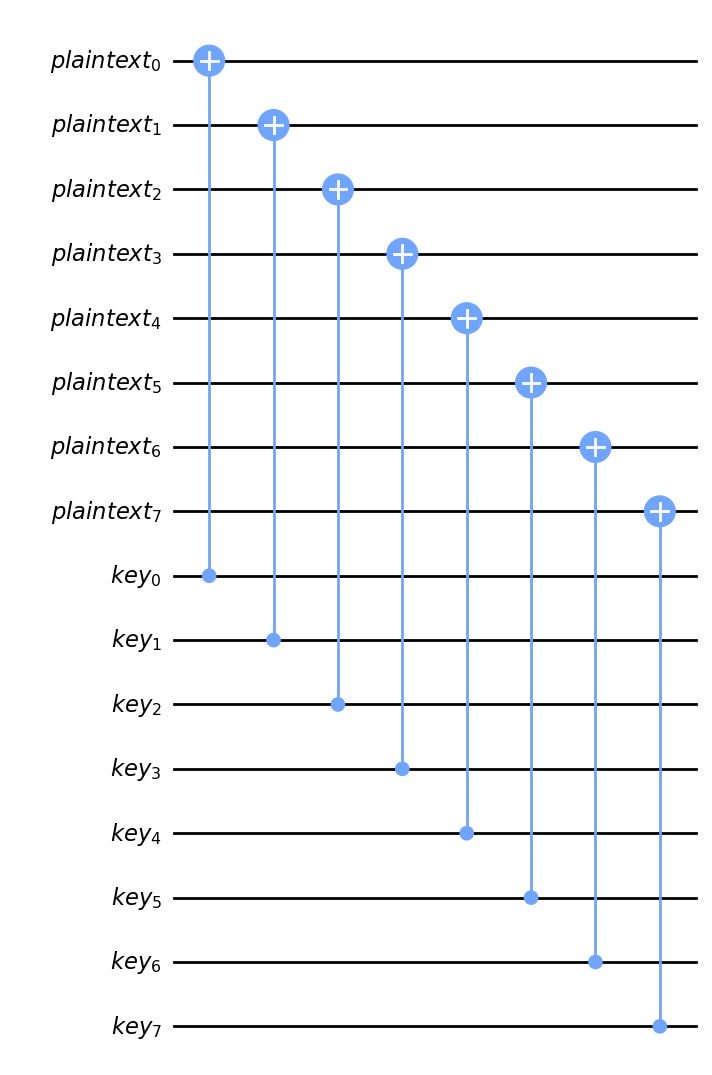

In [7]:
p = QuantumRegister(n, name='plaintext')
k = QuantumRegister(n, name='key')
addRoundkey = QuantumCircuit(p,k,name='addRoundkey')
for i in range(n):
    addRoundkey.cx(k[i],p[i])
addRoundkey.to_gate()
addRoundkey.draw('mpl')

The second step is Sbox. The sbox has been constructed thanks to the [DORCIS tool](https://github.com/matthewchunqed/DORCIS-public).

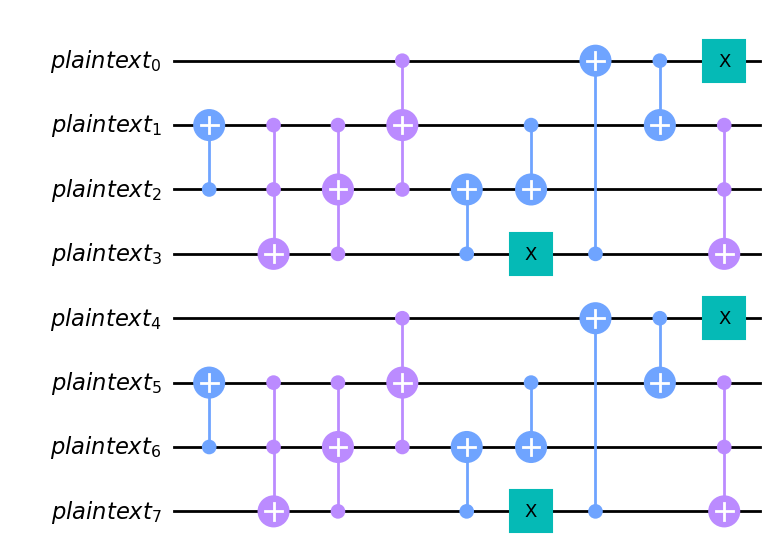

In [8]:
sbox = QuantumCircuit(p,name='sbox')
for i in [0,4]:
    sbox.cx(p[2+i],p[1+i])
    sbox.ccx(p[1+i],p[2+i],p[3+i])
    sbox.ccx(p[3+i],p[1+i],p[2+i])
    sbox.ccx(p[0+i],p[2+i],p[1+i])
    sbox.cx(p[3++i],p[2+i])
    sbox.x(p[3+i])
    sbox.cx(p[1+i],p[2+i])
    sbox.cx(p[3+i],p[0+i])
    sbox.cx(p[0+i],p[1+i])
    sbox.x(p[0+i])
    sbox.ccx(p[1+i],p[2+i],p[3+i])
sbox.to_gate()
sbox.draw('mpl')

Permutation step.

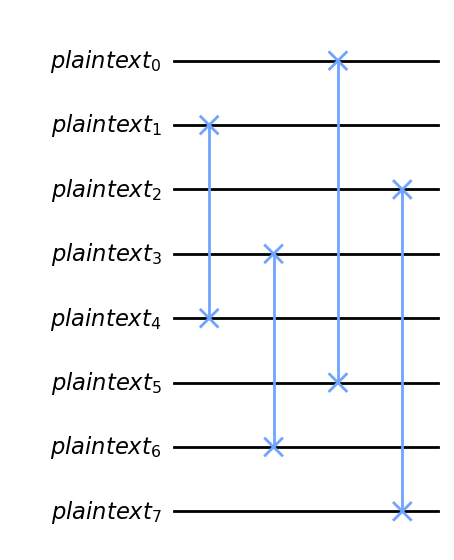

In [9]:
# Permutation
swap = QuantumCircuit(p,name='swap')
swap.swap(p[1],p[4])
swap.swap(p[6],p[3])
swap.swap(p[5],p[0])
swap.swap(p[2],p[7])
swap.to_gate()
swap.draw('mpl')

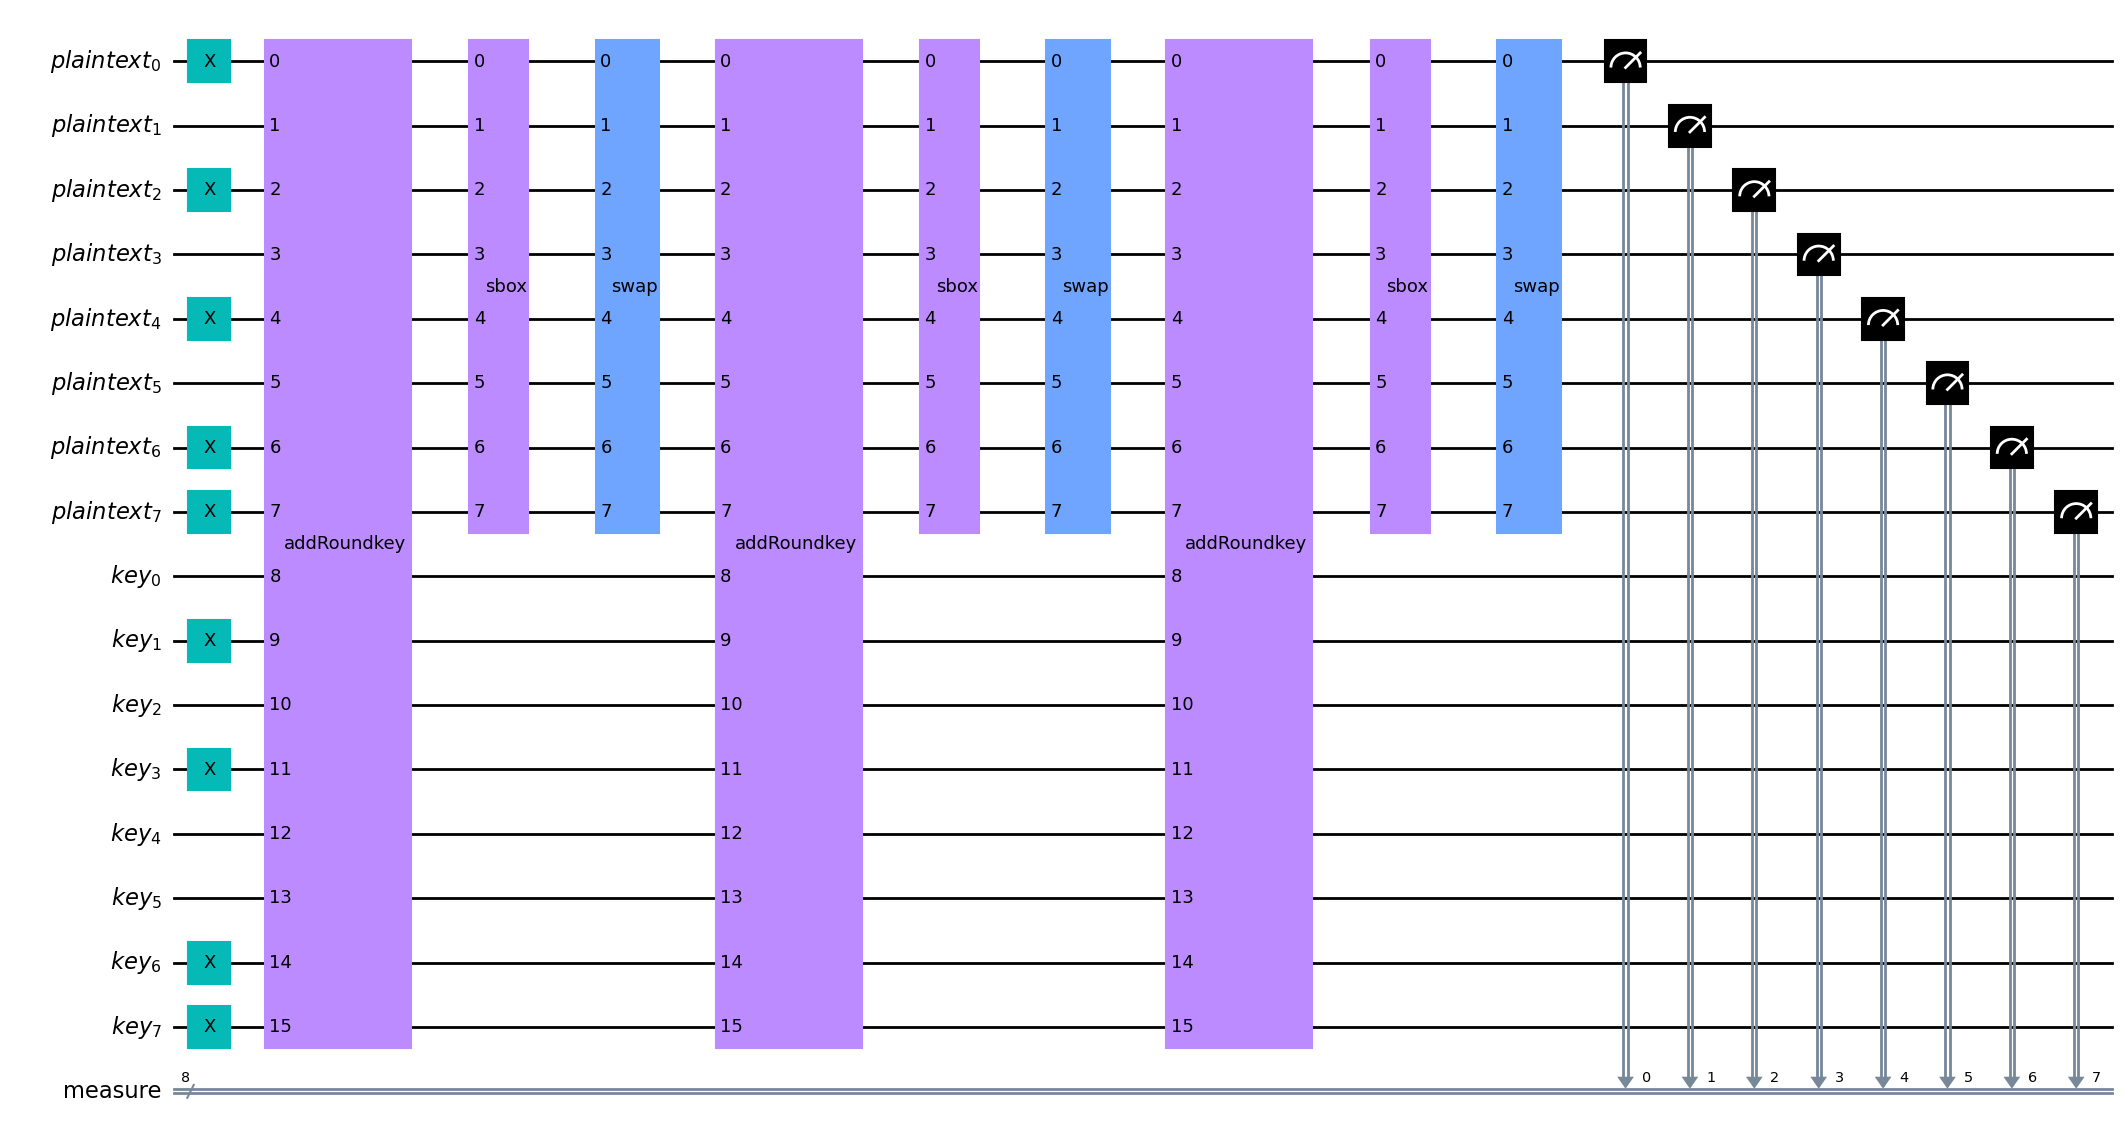

In [10]:
# Quantum Circuit for Encryption
rounds=3
backend = Aer.get_backend('qasm_simulator')
m = ClassicalRegister(n, name='measure')
bcipher = QuantumCircuit(p,k,m)

# Initialize values for the plaintext and key

for i in range(n):
    if plaintext[i] == 1:
        bcipher.x(p[n-i-1])
    if key[i] == 1:
        bcipher.x(k[n-i-1])

# Add steps
for i in range(rounds):
    bcipher.append(addRoundkey,range(2*n))
    bcipher.append(sbox,range(n))
    bcipher.append(swap,range(n))
bcipher.measure(p,m)
bcipher.draw(output='mpl',fold=-1)

Execute the simulator to get the ciphertext.

In [11]:
# Encrypt and get the ciphertext
job = execute(bcipher,backend)
result = job.result()
result.get_counts()

{'11011010': 1024}

# Toy Cipher - Decryption

The decryption process is similar to the encryption process. We use the ciphertext instead of the plaintext.

In [12]:
c = QuantumRegister(n, name='ciphertext')

An inverse version of the Sbox is used instead of the original Sbox.

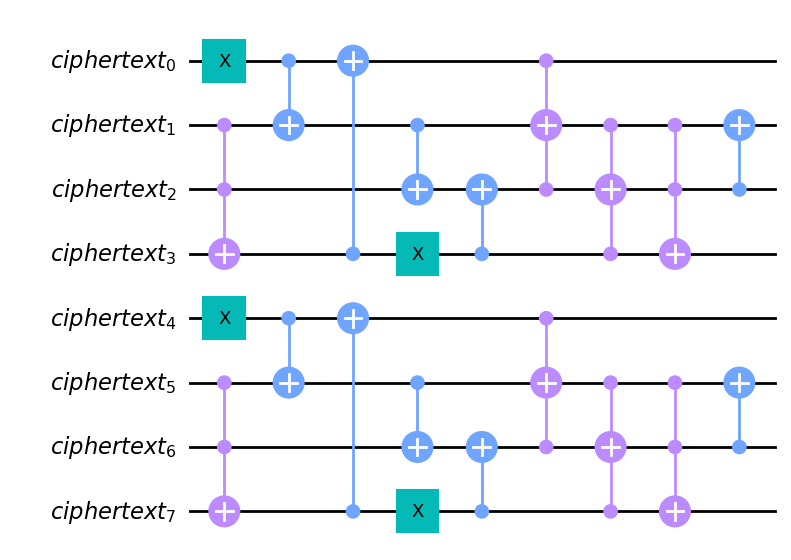

In [13]:
# Inverse of the Sbox
in_sbox = QuantumCircuit(c,name='in_sbox')
for i in [0,4]:
    in_sbox.ccx(c[1+i],c[2+i],c[3+i])
    in_sbox.x(c[0+i])
    in_sbox.cx(c[0+i],c[1+i])
    in_sbox.cx(c[3+i],c[0+i])
    in_sbox.cx(c[1+i],c[2+i])
    in_sbox.x(c[3+i])
    in_sbox.cx(c[3++i],c[2+i])
    in_sbox.ccx(c[0+i],c[2+i],c[1+i])
    in_sbox.ccx(c[3+i],c[1+i],c[2+i])
    in_sbox.ccx(c[1+i],c[2+i],c[3+i])
    in_sbox.cx(c[2+i],c[1+i])
in_sbox.to_gate()
in_sbox.draw('mpl')

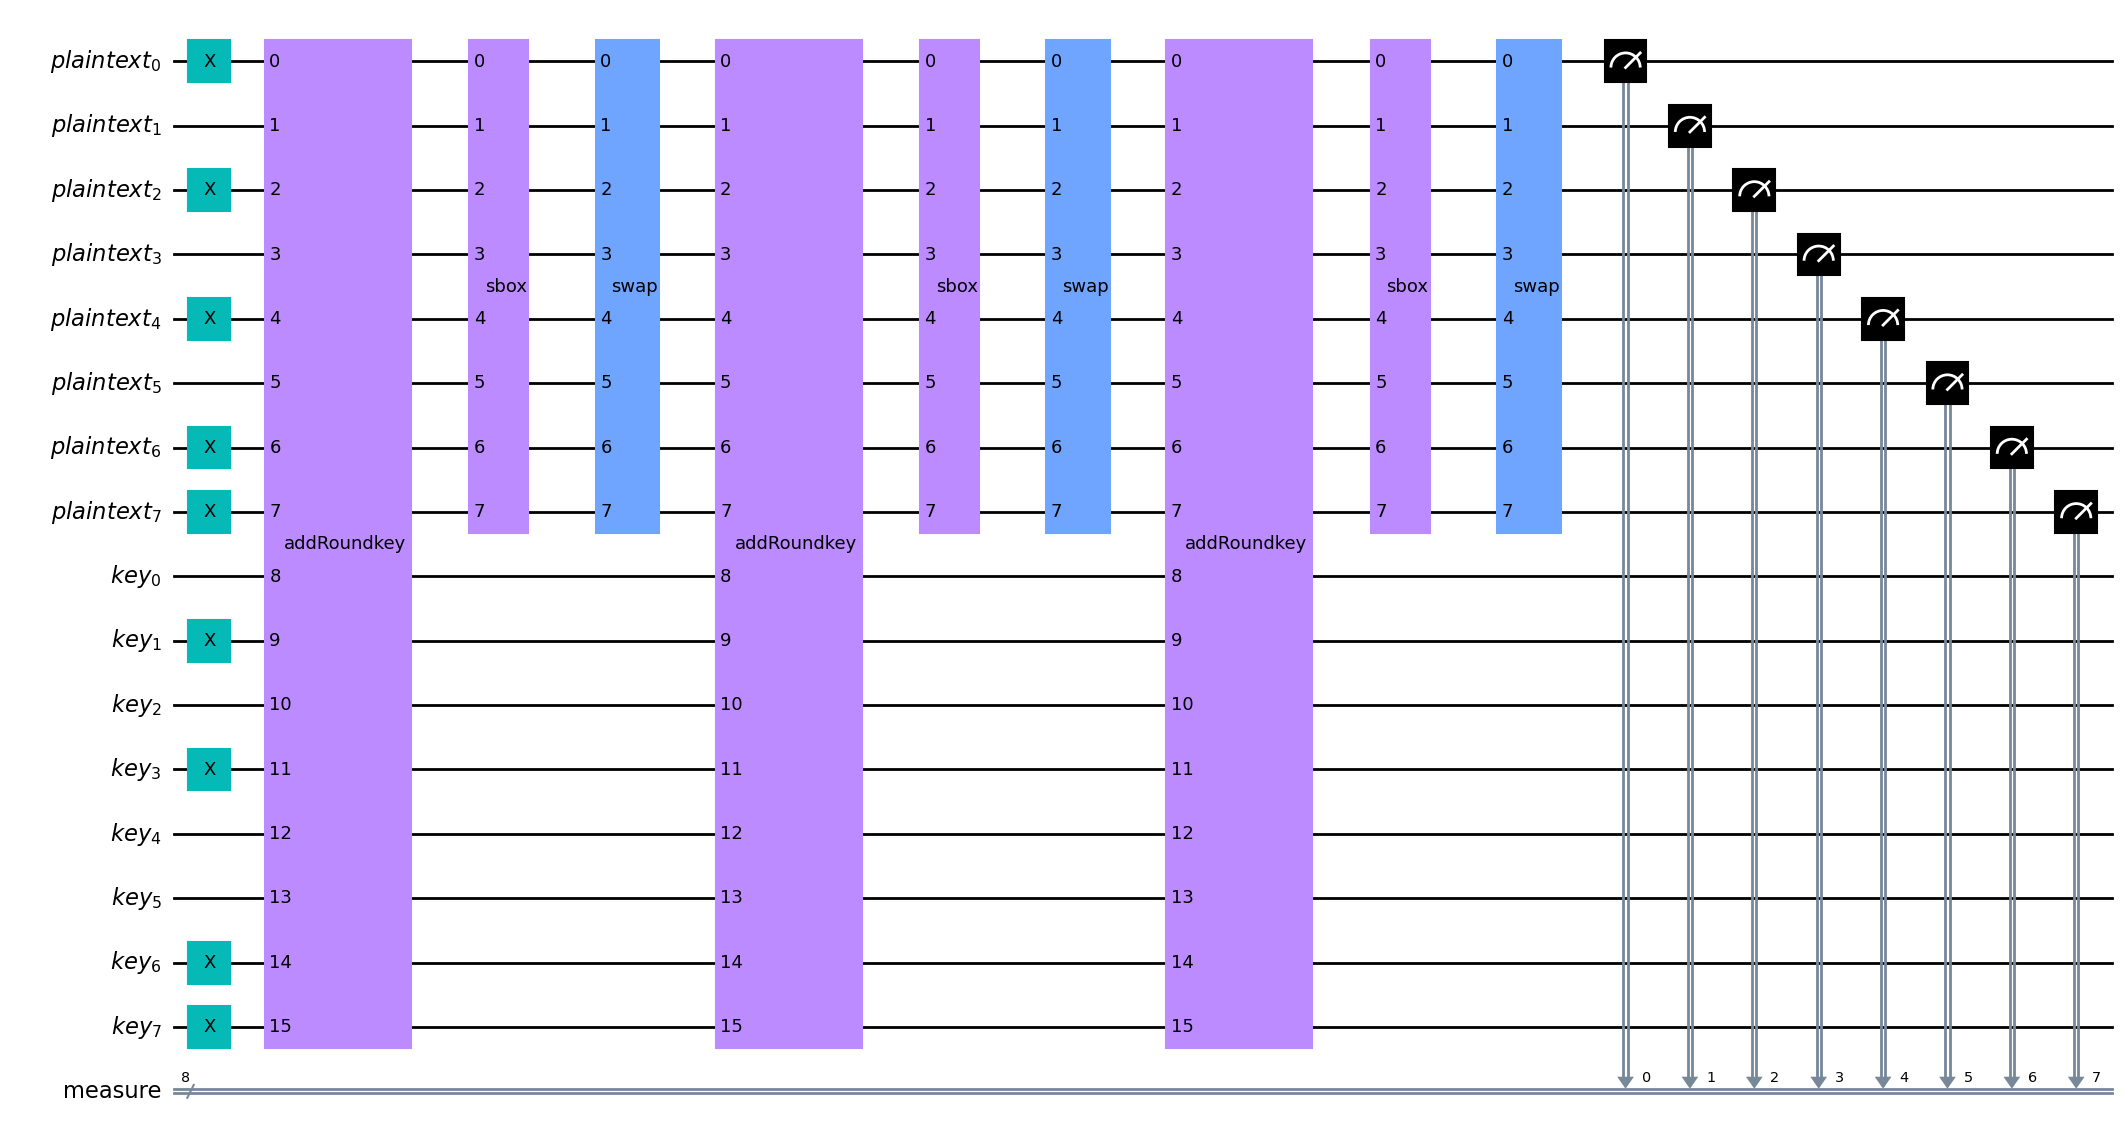

In [14]:
# Quantum Circuit for Decryption
ciphertext=[1,1,0,1,1,0,1,0]
backend = Aer.get_backend('qasm_simulator')
bdecipher = QuantumCircuit(c,k,m)

# Initialize values for the ciphertext and key
for i in range(n):
    if key[i] == 1:
        bdecipher.x(k[n-i-1])
    if ciphertext[i] == 1:
        bdecipher.x(c[n-i-1])

# Add steps
for i in range(rounds):
    bdecipher.append(swap,range(n))
    bdecipher.append(in_sbox,range(n))
    bdecipher.append(addRoundkey,range(n*2))
bdecipher.measure(range(n),range(n))
bcipher.draw(output='mpl',fold=-1)

In [15]:
# Decrypt and get the plaintext
job = execute(bdecipher,backend)
result = job.result()
result.get_counts()

{'11010101': 1024}

# Grover's algorithm
First, we define Encryption and Decryption as Gates to use in the Oracle.

In [16]:
def encrypt(circuit):
    
    for i in range(n):
        if plaintext[i] == 1:
            circuit.x(p[n-i-1])
    for i in range(rounds):
        circuit.append(addRoundkey,range(2*n))
        circuit.append(sbox,range(n))
        circuit.append(swap,range(n))
        
def decrypt(circuit):
    for i in range(rounds):
        circuit.append(swap,range(n))
        circuit.append(in_sbox,range(n))
        circuit.append(addRoundkey,range(2*n))
    for i in range(n):
        if plaintext[i] == 1:
            circuit.x(p[n-i-1])

The Oracle does not know the cipher key. It only knows the plaintext and the cipher text.\
We use the Oracle to perform Exhaustive Key Search with qubits.\
If the input is the correct key, the Oracle changes the phase of its state to a negative phase.\
Hence, the solution state will differ from the rest and can be measured at the end.

##  Plaintext and key
We generate here a random plaintext and key to later use in Grover's algorithm (this section has been commented out because of spurious keys problems. It is addressed at the end of the notebook).

In [17]:
# plaintext = [random.randrange(0,2) for i in range(n)]
# key = [random.randrange(0,2) for i in range(n)]
plaintext=[1, 1, 0, 0, 0, 1, 1, 1]
key=[1, 0, 0, 0, 1, 0, 1, 1]
print("In the following application of grover, we are going to use the following plaintext: ", plaintext)
print("In the following application of grover, we are will have to find this key: ", key)

In the following application of grover, we are going to use the following plaintext:  [1, 1, 0, 0, 0, 1, 1, 1]
In the following application of grover, we are will have to find this key:  [1, 0, 0, 0, 1, 0, 1, 1]


## Ciphertext
Since we use Grover's algorithm for a Known-plaintext attack (KPA), we need to compute the ciphertext beforehand.

In [18]:
backend = Aer.get_backend('qasm_simulator')
bdecipher = QuantumCircuit(p,k,m)

for i in range(n):
    if key[i] == 1:
        bdecipher.x(k[n-i-1])
    
encrypt(bdecipher)
# Add steps

bdecipher.measure(range(n),range(n))

job = execute(bdecipher,backend)
result = job.result()

a=list(result.get_counts())
ciphertext=[int(a[0][i]) for i in range(n)]
print("The ciphertext which will be used is: ", ciphertext)
ciphertext.reverse()

The ciphertext which will be used is:  [1, 0, 0, 0, 1, 1, 0, 0]


In [19]:
# Create Quantum Circuit

backend = Aer.get_backend('qasm_simulator')
k = QuantumRegister(n, name='k')
p = QuantumRegister(n, name='pt')
trg = QuantumRegister(1, name = 'trg')
anc = QuantumRegister(6, name = 'anc')
cbits = ClassicalRegister(n, name='c')

# This qubit to mark if an input is the key or not
output_qubit = QuantumRegister(1, name='out')

grover_circ = QuantumCircuit(p, k, trg, anc, cbits)

# for i in range(n):
#     if key[i]==1:
#         grover_circ.x(k[n-i-1])

for i in range(n):
    grover_circ.h(k[i])

grover_circ.x(trg[0])

for i in range(math.ceil((math.pi/4)*math.sqrt(pow(2,n)))):
    encrypt(grover_circ)
    oracle_phase_flip(ciphertext, grover_circ, p, trg, anc)
    decrypt(grover_circ)
    Diffusion(n, grover_circ, k, trg, anc)

for i in range(n):
    grover_circ.measure(k[i],cbits[i])

After running Grover's algorithm, we measure the result. We can see that the correct key has a high probability of being measured.\
Thus, the algorithm works correctly.

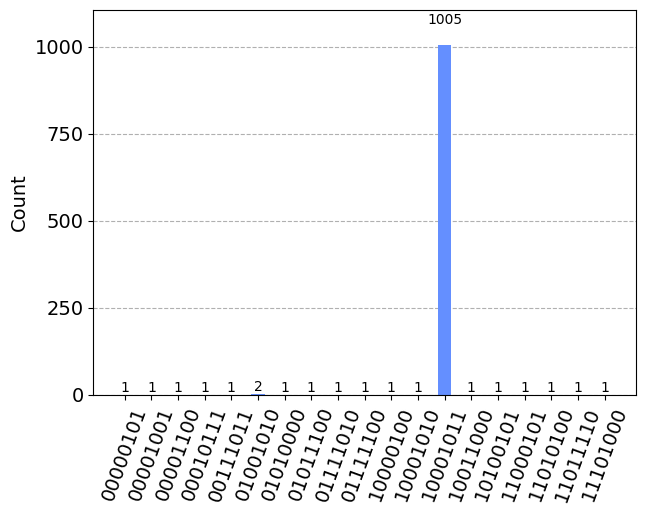

In [20]:
# Simulate and plot results
job = execute(grover_circ,backend)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

We can see by sorting the counts variable and printing it that the actual key corresponds to the spike.

In [21]:
counts=sorted(counts.items(), key=lambda x: x[1], reverse=True)
print(counts)

[('10001011', 1005), ('01001010', 2), ('00001001', 1), ('10000100', 1), ('10001010', 1), ('01111100', 1), ('01011100', 1), ('00001100', 1), ('11000101', 1), ('11101000', 1), ('00000101', 1), ('10011000', 1), ('11010100', 1), ('00010111', 1), ('01111010', 1), ('11011110', 1), ('00111011', 1), ('10100101', 1), ('01010000', 1)]


# Spurious keys
Our cipher being a toy, gives the same ciphertext/plaintext pairs in some cases, the keys that give this result are called spurious keys. In this case, we might need more than one ciphertext/plaintext pair to conduct the attack.

In [22]:
plaintext=[1, 0, 1, 1, 0, 1, 0, 0]
key=[1, 1, 0, 0, 0, 1, 1, 1]

In [23]:
backend = Aer.get_backend('qasm_simulator')
bdecipher = QuantumCircuit(p,k,m)

for i in range(n):
    if key[i] == 1:
        bdecipher.x(k[n-i-1])
    
encrypt(bdecipher)
# Add steps

bdecipher.measure(range(n),range(n))

job = execute(bdecipher,backend)
result = job.result()

a=list(result.get_counts())
ciphertext=[int(a[0][i]) for i in range(n)]
print("The ciphertext which will be used is: ", ciphertext)
ciphertext.reverse()

The ciphertext which will be used is:  [0, 1, 0, 1, 1, 1, 0, 1]


In [24]:
backend = Aer.get_backend('qasm_simulator')
k = QuantumRegister(n, name='k')
p = QuantumRegister(n, name='pt')
trg = QuantumRegister(1, name = 'trg')
anc = QuantumRegister(6, name = 'anc')
cbits = ClassicalRegister(n, name='c')

# This qubit to mark if an input is the key or not
output_qubit = QuantumRegister(1, name='out')

grover_circ = QuantumCircuit(p, k, trg, anc, cbits)

# for i in range(n):
#     if key[i]==1:
#         grover_circ.x(k[n-i-1])

for i in range(n):
    grover_circ.h(k[i])

grover_circ.x(trg[0])

for i in range(16):
    encrypt(grover_circ)
    oracle_phase_flip(ciphertext, grover_circ, p, trg, anc)
    decrypt(grover_circ)
    Diffusion(8, grover_circ, k, trg, anc)

for i in range(8):
    grover_circ.measure(k[i],cbits[i])
    


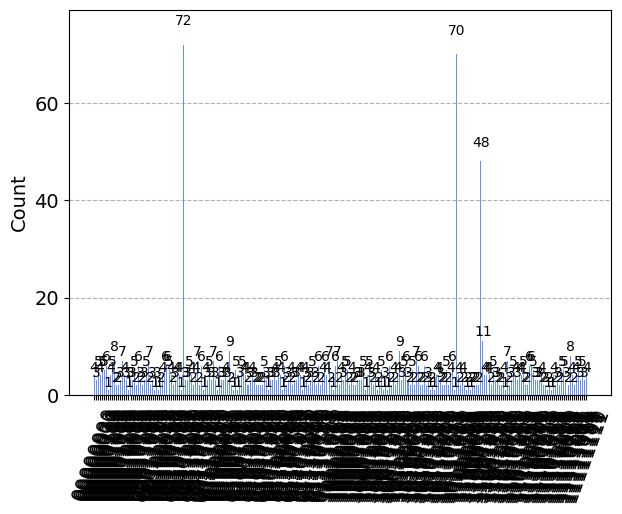

In [25]:
# Simulate and plot results
job = execute(grover_circ,backend)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

We can see that multiple keys (3) in this case are being measured with a high probability. We can check if these keys give the same ciphertext, for our given plaintext.

In [26]:
print(sorted(counts.items(), key=lambda x: x[1], reverse=True))

[('00101110', 72), ('10111011', 70), ('11000111', 48), ('11001000', 11), ('10011110', 9), ('01000110', 9), ('00001010', 8), ('11110111', 8), ('10100110', 7), ('00110101', 7), ('00111101', 7), ('11010100', 7), ('01111111', 7), ('00011011', 7), ('00001110', 7), ('01111011', 7), ('00100100', 6), ('10100001', 6), ('10111001', 6), ('10100111', 6), ('01110110', 6), ('00100101', 6), ('00010110', 6), ('00110111', 6), ('11100001', 6), ('10101010', 6), ('01000001', 6), ('01111001', 6), ('01111110', 6), ('00000110', 6), ('11100000', 6), ('01100010', 6), ('10011001', 6), ('00011010', 5), ('00001001', 5), ('11111011', 5), ('00000100', 5), ('11100010', 5), ('10100100', 5), ('00110001', 5), ('10001100', 5), ('01011000', 5), ('00100110', 5), ('10010101', 5), ('00000101', 5), ('10110110', 5), ('00000010', 5), ('01001101', 5), ('11110011', 5), ('01110011', 5), ('11011100', 5), ('01011111', 5), ('00010100', 5), ('11110010', 5), ('00111011', 5), ('10000100', 5), ('10100000', 5), ('11010111', 5), ('0100101

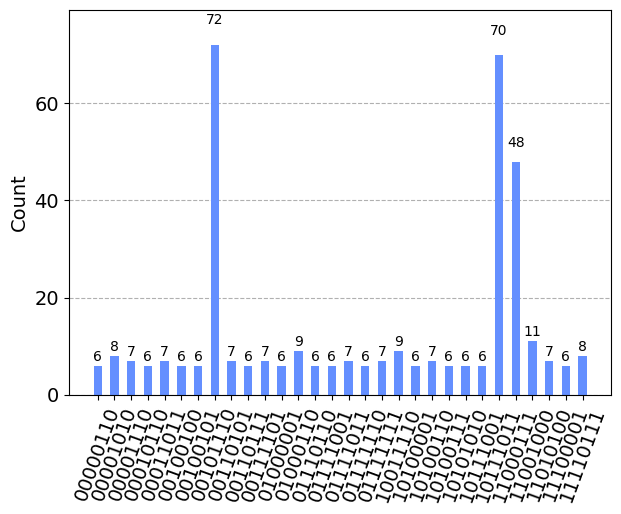

In [27]:
counts=sorted(counts.items(), key=lambda x: x[1], reverse=True)
plot_histogram(dict(counts[0:30]))

For better visibility on the x-axis, we print the 30 most measured keys. The 3 keys that stand out are 00101110, 10111011, and our actual key 11000111.\
Let's try encrypting with these 2 other keys, to see why they are measured more than necessary.
## Is key 00101110 spurious?

In [28]:
plaintext=[1, 0, 1, 1, 0, 1, 0, 0]

key=[0, 0, 1, 0, 1, 1, 1, 0]

backend = Aer.get_backend('qasm_simulator')
bdecipher = QuantumCircuit(p,k,m)

for i in range(n):
    if key[i] == 1:
        bdecipher.x(k[n-i-1])
    
encrypt(bdecipher)
# Add steps

bdecipher.measure(range(n),range(n))

job = execute(bdecipher,backend)
result = job.result()

a=list(result.get_counts())
ciphertext2=[int(a[0][i]) for i in range(n)]
ciphertext2.reverse()
if ciphertext2==ciphertext:
    print("ciphertexts are identical, key is spurious")
else: print("ciphertext different, this is not a spurious key")

ciphertexts are identical, key is spurious


## Is key 10111011 spurious ?

In [29]:
plaintext=[1, 0, 1, 1, 0, 1, 0, 0]

key=[1, 0, 1, 1, 1, 0, 1, 1]

backend = Aer.get_backend('qasm_simulator')
bdecipher = QuantumCircuit(p,k,m)

for i in range(n):
    if key[i] == 1:
        bdecipher.x(k[n-i-1])
    
encrypt(bdecipher)
# Add steps

bdecipher.measure(range(n),range(n))

job = execute(bdecipher,backend)
result = job.result()

a=list(result.get_counts())
ciphertext3=[int(a[0][i]) for i in range(n)]
ciphertext3.reverse()
if ciphertext3==ciphertext:
    print("ciphertexts are identical, key is spurious")
else: print("ciphertext different, this is not a spurious key")

ciphertexts are identical, key is spurious


We can see that all the 3 keys that stand out in the measurement after applying Grover's algorithm give the same ciphertext.\
Let's try another ciphertext/plaintext pair.

In [30]:
key=[1, 1, 0, 0, 0, 1, 1, 1] #the key that we want to measure
plaintext=[0, 0, 0, 0, 1, 1, 0, 1]

backend = Aer.get_backend('qasm_simulator')
bdecipher = QuantumCircuit(p,k,m)

for i in range(n):
    if key[i] == 1:
        bdecipher.x(k[n-i-1])
    
encrypt(bdecipher)
# Add steps

bdecipher.measure(range(n),range(n))

job = execute(bdecipher,backend)
result = job.result()

a=list(result.get_counts())
ciphertext=[int(a[0][i]) for i in range(n)]
print("The ciphertext which will be used is: ", ciphertext)
ciphertext.reverse()

The ciphertext which will be used is:  [0, 1, 0, 0, 0, 1, 1, 1]


In [31]:
backend = Aer.get_backend('qasm_simulator')
k = QuantumRegister(n, name='k')
p = QuantumRegister(n, name='pt')
trg = QuantumRegister(1, name = 'trg')
anc = QuantumRegister(6, name = 'anc')
cbits = ClassicalRegister(n, name='c')

# This qubit to mark if an input is the key or not
output_qubit = QuantumRegister(1, name='out')

grover_circ = QuantumCircuit(p, k, trg, anc, cbits)

# for i in range(n):
#     if key[i]==1:
#         grover_circ.x(k[n-i-1])

for i in range(n):
    grover_circ.h(k[i])

grover_circ.x(trg[0])

for i in range(16):
    encrypt(grover_circ)
    oracle_phase_flip(ciphertext, grover_circ, p, trg, anc)
    decrypt(grover_circ)
    Diffusion(8, grover_circ, k, trg, anc)

for i in range(8):
    grover_circ.measure(k[i],cbits[i])
    

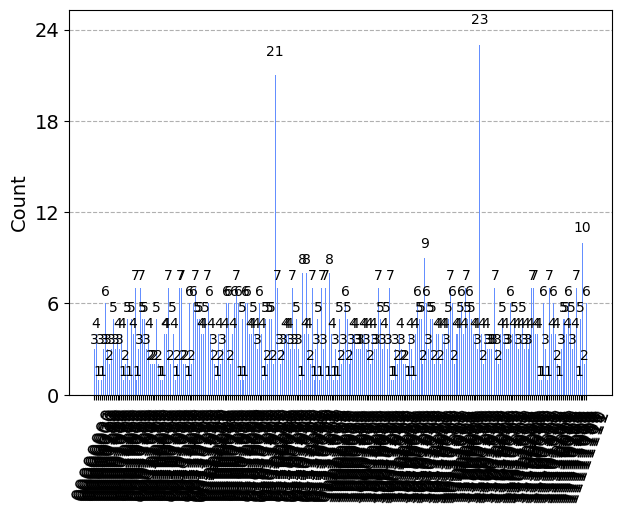

In [32]:
job = execute(grover_circ,backend)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [33]:
print(sorted(counts.items(), key=lambda x: x[1], reverse=True))

[('11000111', 23), ('01011110', 21), ('11111101', 10), ('10101011', 9), ('01111010', 8), ('01101100', 8), ('01101110', 8), ('00101100', 7), ('00100110', 7), ('01110001', 7), ('00111010', 7), ('01001001', 7), ('00011000', 7), ('11000000', 7), ('00101101', 7), ('11100011', 7), ('10010011', 7), ('01100111', 7), ('10011001', 7), ('11111010', 7), ('00110100', 7), ('00010101', 7), ('01011111', 7), ('01110110', 7), ('01111000', 7), ('11101100', 7), ('11001111', 7), ('11100010', 7), ('10111000', 7), ('01001000', 6), ('01001010', 6), ('11101000', 6), ('11101110', 6), ('00110011', 6), ('00111011', 6), ('10100111', 6), ('11110110', 6), ('01010110', 6), ('10101100', 6), ('00000110', 6), ('10000010', 6), ('00110001', 6), ('01001110', 6), ('11010111', 6), ('01010000', 6), ('11111111', 6), ('01000100', 6), ('01000101', 6), ('10111110', 6), ('10111001', 6), ('11000010', 6), ('10110111', 5), ('01011100', 5), ('11010011', 5), ('00110101', 5), ('00101000', 5), ('11110011', 5), ('01010011', 5), ('10010111

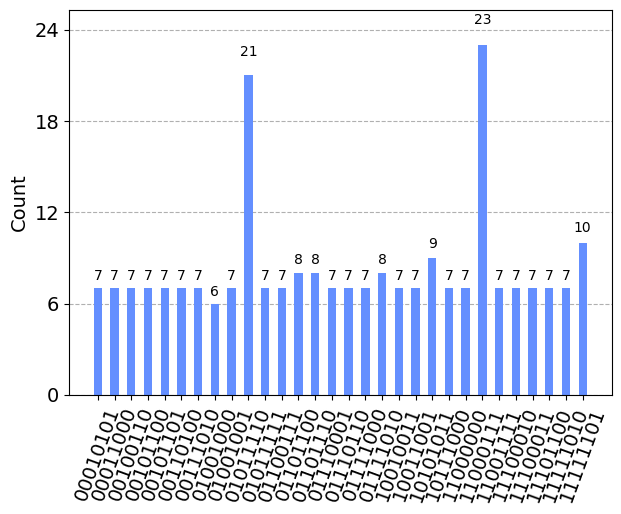

In [34]:
counts=sorted(counts.items(), key=lambda x: x[1], reverse=True)
plot_histogram(dict(counts[0:30]))

Bingo! With the second pair, we can omit all the keys that were candidates for the first encryption since:

- The first encryption gave 00101110, 11000111, and 10111011 as potential keys (2 spurious keys).
- The second one gave 11000111, 01011110 (1 spurious key).

The key that is measured with a high chance in both instances of Grover's algorithm, with different ciphertext/plaintext pair should be the right key, and it is in this case (the only key in both sets is 11000111 which is the right one).